In [1]:
reset -fs

In [2]:
# import libraries
import pandas as pd
import numpy as np
import re
import string
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Read in data

In [3]:
modern_love_df = pd.read_csv('modern_love_df.csv')

In [4]:
modern_love_df.shape

(1615, 12)

In [5]:
modern_love_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   article_url             1615 non-null   object
 1   article                 1609 non-null   object
 2   article_id              1615 non-null   object
 3   article_headline        1615 non-null   object
 4   article_abstract        1615 non-null   object
 5   article_snippet         1615 non-null   object
 6   article_lead_paragraph  1604 non-null   object
 7   article_pub_date        1615 non-null   object
 8   article_news_desk       1615 non-null   object
 9   article_section         1615 non-null   object
 10  article_type_material   1615 non-null   object
 11  article_word_count      1615 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 151.5+ KB


# Clean data

In [6]:
pd.set_option("display.max_colwidth", 1)

In [7]:
# drop rows with na in article column

modern_love_df = modern_love_df.dropna(subset=['article'])

In [8]:
modern_love_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1614
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   article_url             1609 non-null   object
 1   article                 1609 non-null   object
 2   article_id              1609 non-null   object
 3   article_headline        1609 non-null   object
 4   article_abstract        1609 non-null   object
 5   article_snippet         1609 non-null   object
 6   article_lead_paragraph  1599 non-null   object
 7   article_pub_date        1609 non-null   object
 8   article_news_desk       1609 non-null   object
 9   article_section         1609 non-null   object
 10  article_type_material   1609 non-null   object
 11  article_word_count      1609 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 163.4+ KB


In [9]:
# rename article column

modern_love_df = modern_love_df.rename({'article':'essay'}, axis=1)

In [10]:
# rename the rest of the columns by removing 'article_'

modern_love_df.columns = modern_love_df.columns.str.replace('article_',"")

In [11]:
# check for duplicated rows

modern_love_df.duplicated().sum() # there are none!

0

In [12]:
# convert pub_date to datetime and then keep only the date

modern_love_df['pub_date'] = pd.to_datetime(modern_love_df['pub_date']).dt.date

In [13]:
modern_love_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1614
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             1609 non-null   object
 1   essay           1609 non-null   object
 2   id              1609 non-null   object
 3   headline        1609 non-null   object
 4   abstract        1609 non-null   object
 5   snippet         1609 non-null   object
 6   lead_paragraph  1599 non-null   object
 7   pub_date        1609 non-null   object
 8   news_desk       1609 non-null   object
 9   section         1609 non-null   object
 10  type_material   1609 non-null   object
 11  word_count      1609 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 163.4+ KB


In [17]:
# see how many articles mention the nytimes in the essay, as this text should be removed

len(modern_love_df[modern_love_df.essay.str.contains('nytimes|New York Times|NYT')])

108

In [18]:
# drop these essays for times' sake (go back to data acquisition stage to remove these paragraphs, time permitting)

modern_love_df_rev = modern_love_df[~modern_love_df.essay.str.contains('nytimes|New York Times|NYT')]

In [19]:
# see how many essays mention 'This essay is part of a collaborative project with Black History, Continued. We invited readers and renowned writers to respond to the question “What is Black love today?”'

print(len(modern_love_df_rev[modern_love_df_rev.essay.str.contains('collaborative project')]))

8


In [20]:
# remove the sentences 'This essay is part of a collaborative project with Black History, Continued. We invited readers and renowned writers to respond to the question “What is Black love today?”'
    # from the essay column

sentences_to_remove = 'This essay is part of a collaborative project with Black History, Continued. We invited readers and renowned writers to respond to the question “What is Black love today?” '
print(len(sentences_to_remove))

collaborative_project = modern_love_df_rev[modern_love_df_rev.essay.str.contains('collaborative project')]

revised_text = []

for row in collaborative_project['essay']:
    row = row[172:]
    revised_text.append(row)
    
index = collaborative_project['id']

data_tuples = list(zip(index,revised_text))
cleaned_essay = pd.DataFrame(data_tuples, columns=['id','essay_rev'])

modern_love_df_rev = modern_love_df.merge(cleaned_essay,how='left',on='id')
modern_love_df_rev['essay_rev'].fillna(modern_love_df_rev.essay, inplace=True)

172


In [21]:
# check how many essays include text for the link '[Sign up for Love Letter, our weekly email about Modern Love, weddings and relationships.]'

len(modern_love_df_rev.loc[modern_love_df_rev.essay_rev.str.contains('Sign up for Love Letter')])

111

In [22]:
# remove the sign-up link text from each article

modern_love_df_rev['essay_rev'] = modern_love_df_rev['essay_rev'].str.replace(r'\[.*?\]','')

In [23]:
# check how many essays have 'Modern Love' in them

len(modern_love_df_rev.loc[modern_love_df_rev.essay_rev.str.contains('Modern Love|modernlove')])

151

In [24]:
# drop these essays 

modern_love_df_rev_2 = modern_love_df_rev.loc[~modern_love_df_rev.essay_rev.str.contains('Modern Love|modernlove')]

In [25]:
modern_love_df_rev_2.shape

(1458, 13)

# Topic modeling utility

Before creating a baseline model, create a pipeline function that does the following:

- Arguments are the corpus, vectorizer and topic_modeler
- Applies these in order
- Prints the top 10 words for each topic found from training

In [726]:
def make_topics(corpus, vectorizer, topic_modeler, print_n_words=10):
    """A very simple pipeline."""
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(corpus) 
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = doc_word_vectors.get_feature_names_out() # vectorizer
    for idx, topic in enumerate(doc_topic_vectors.components_): # topic_modeler
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i] for i in topic.argsort()[:-print_n_words-1:-1]]
        #print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
        print(f"Topic {idx}:", ", ".join(top_words))
        
    return doc_topic_vectors

# NMF baseline model

As priors, use Tfidf vectorizer and NMF topic modeler

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [28]:
corpus = modern_love_df_rev_2['essay_rev']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(5, random_state=42, max_iter=1000) # start with 5 topics

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: the, and, of, to, in, that, was, it, had, my
Topic 1: she, her, was, to, and, the, me, had, in, for
Topic 2: he, his, him, to, was, me, and, said, had, you
Topic 3: we, our, and, in, the, to, you, us, other, together
Topic 4: my, mother, father, me, to, parents, and, with, in, for


array([[0.12026731, 0.        , 0.1151798 , 0.03879698, 0.01190443],
       [0.10574248, 0.01946263, 0.06163275, 0.05058978, 0.03135195],
       [0.06828757, 0.15704441, 0.        , 0.00618065, 0.07139688],
       ...,
       [0.        , 0.        , 0.05832072, 0.04512847, 0.        ],
       [0.03195689, 0.        , 0.        , 0.00845712, 0.0650467 ],
       [0.05628714, 0.00129334, 0.00476101, 0.013898  , 0.02507168]])

Looks like the topics are capturing lots of stop words - time to remove them!

# NMF Model 2 - remove stop words, numbers, punctuation and lemmatize tokens

Use spaCy package for text processing

In [29]:
import spacy
from spacy.tokens import Token
nlp = spacy.load('en_core_web_sm')

In [30]:
# import stopwords
sw_spacy = nlp.Defaults.stop_words

The below code was inspired by this <a href="https://stackoverflow.com/questions/47523112/detect-stopword-after-lemma-in-spacy">this stackoverflow post</a>

In [31]:
# update stopwords to ensure that capitalized and lemmatized tokens are identified as stop words

stop_words_getter = lambda token: token.is_stop or token.lower_ in sw_spacy or token.lemma_ in sw_spacy
Token.set_extension('is_stop', getter=stop_words_getter, force=True)  # set attribute with getter

In [32]:
docs = list(nlp.pipe(modern_love_df_rev_2['essay_rev']))

The below code was inspired by <a href="https://stackoverflow.com/questions/25692293/inserting-a-link-to-a-webpage-in-an-ipython-notebook">this stackoverflow post</a>

In [33]:
docs_clean = [[token.lemma_.lower() for token in doc if token.is_alpha and \
                         (not token.is_stop and not token.is_punct and not token.like_num and not token.is_digit)] \
                          for doc in docs]
modern_love_df_rev_2['essay_rev_clean'] = [' '.join(map(str, l)) for l in docs_clean]

<ipython-input-33-3405cf085942>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modern_love_df_rev_2['essay_rev_clean'] = [' '.join(map(str, l)) for l in docs_clean]


In [34]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(5, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: day, time, like, say, home, go, night, bed, leave, know
Topic 1: father, mother, parent, family, say, brother, year, sister, child, know
Topic 2: say, date, like, want, man, know, think, tell, woman, meet
Topic 3: husband, marriage, divorce, wife, marry, child, year, wedding, friend, life
Topic 4: love, fall, year, grandmother, girl, boy, know, feel, relationship, child


array([[0.07236249, 0.05994489, 0.05163971, 0.02300993, 0.03358636],
       [0.01151929, 0.06829537, 0.01585402, 0.06786783, 0.07423379],
       [0.03034165, 0.02797976, 0.0203942 , 0.00605542, 0.13180721],
       ...,
       [0.02773193, 0.        , 0.        , 0.01958957, 0.04469718],
       [0.02239977, 0.00234048, 0.        , 0.10264239, 0.        ],
       [0.04431684, 0.        , 0.01291339, 0.        , 0.01675162]])

# NMF Model 3 - try 10 topics

In [35]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(10, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: mother, grandmother, year, family, sister, parent, home, old, die, care
Topic 1: father, parent, mother, brother, dad, family, know, year, sister, die
Topic 2: date, like, want, relationship, man, feel, woman, friend, know, time
Topic 3: husband, marriage, divorce, wife, marry, year, wedding, friend, man, life
Topic 4: love, fall, year, word, know, heart, feel, relationship, people, write
Topic 5: say, ask, tell, know, think, want, yes, like, look, later
Topic 6: day, time, night, new, home, like, car, leave, bed, dog
Topic 7: child, baby, daughter, son, doctor, birth, pregnancy, pregnant, know, husband
Topic 8: john, amy, mary, house, slipper, year, want, extraordinary, day, sofa
Topic 9: girl, school, boy, prom, parent, michael, high, gay, dress, year


array([[0.00611814, 0.0547847 , 0.05585934, ..., 0.12416781, 0.        ,
        0.        ],
       [0.03177836, 0.05230815, 0.00942886, ..., 0.01877506, 0.001906  ,
        0.02563816],
       [0.01113183, 0.0195127 , 0.02676823, ..., 0.04980819, 0.00204291,
        0.034947  ],
       ...,
       [0.        , 0.00666873, 0.        , ..., 0.        , 0.00466373,
        0.00651875],
       [0.00162195, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00259708, ..., 0.        , 0.        ,
        0.        ]])

# NMF Model 4 - try 50 topics

In [36]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(50, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: feel, know, relationship, time, want, like, way, life, think, friend
Topic 1: father, dad, mother, parent, know, die, year, death, daddy, life
Topic 2: date, meet, guy, app, friend, year, maybe, try, marry, later
Topic 3: marriage, divorce, wife, marry, year, gay, married, couple, wedding, share
Topic 4: love, fall, year, boyfriend, heart, word, milo, people, write, child
Topic 5: say, ask, tell, know, think, yes, want, like, good, happy
Topic 6: new, apartment, night, york, day, city, work, boyfriend, move, time
Topic 7: baby, child, pregnancy, pregnant, birth, fertility, adoption, egg, doctor, sperm
Topic 8: mother, home, year, old, care, die, day, dj, cry, family
Topic 9: man, woman, guy, white, like, young, find, gay, think, know
Topic 10: john, mary, slipper, house, extraordinary, want, sofa, party, bee, jessica
Topic 11: grandmother, mahjong, tile, nick, game, purse, win, round, aunt, cousin
Topic 12: son, child, house, wife, boy, year, church, god, tree, old
Topic 13: m

array([[0.03785426, 0.04446844, 0.01136468, ..., 0.03843785, 0.05835881,
        0.        ],
       [0.00599239, 0.02545525, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01788923, 0.01264681, 0.00522237, ..., 0.00494933, 0.        ,
        0.        ],
       ...,
       [0.00627784, 0.00466612, 0.        , ..., 0.00769902, 0.001398  ,
        0.0079676 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02583937,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00073479,
        0.        ]])

# NMF Model 5 - try 2 topics

In [37]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(2, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: say, like, love, know, want, time, feel, think, tell, man
Topic 1: mother, father, parent, year, family, child, daughter, say, son, brother


array([[0.08506482, 0.0791229 ],
       [0.04808149, 0.08981857],
       [0.0613017 , 0.05350221],
       ...,
       [0.0325893 , 0.01562112],
       [0.03759431, 0.0286379 ],
       [0.04365331, 0.        ]])

# NMF Model 6 - try 7 topics

In [38]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(7, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: day, time, like, home, bed, night, feel, go, leave, come
Topic 1: father, mother, parent, family, brother, year, sister, child, die, know
Topic 2: date, like, relationship, want, man, friend, feel, know, time, woman
Topic 3: husband, marriage, divorce, wife, marry, child, year, wedding, friend, life
Topic 4: love, grandmother, fall, year, boy, child, girl, parent, know, family
Topic 5: say, ask, tell, know, think, want, like, yes, look, later
Topic 6: john, amy, year, mary, house, slipper, want, school, high, new


array([[6.94770303e-02, 5.95715739e-02, 5.64972297e-02, ...,
        2.49154081e-02, 2.61863639e-02, 0.00000000e+00],
       [1.12106189e-02, 6.71349062e-02, 2.23416241e-02, ...,
        6.87913745e-02, 1.58993337e-02, 3.68147979e-03],
       [3.09364201e-02, 2.69966857e-02, 3.52077018e-02, ...,
        1.22663658e-01, 4.63760672e-03, 2.44690127e-03],
       ...,
       [2.78458568e-02, 0.00000000e+00, 3.78684335e-05, ...,
        4.32893509e-02, 3.50992582e-03, 7.85271941e-03],
       [1.05131888e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.80152476e-02, 0.00000000e+00],
       [3.91264770e-02, 0.00000000e+00, 1.62182190e-02, ...,
        1.08950736e-02, 1.17952016e-02, 5.02625520e-03]])

# NMF Model 7 - 10 topics and remove more stop words

In [494]:
tokens_to_remove = {'like','tell','like','want','say','know','ask','think','thing','man','woman','feel','person', \
                   'people','day','time','night'}

sw_spacy.update(tokens_to_remove)

docs_clean_2 = [[token for token in doc if token not in sw_spacy] for doc in docs_clean]
modern_love_df_rev_2['essay_rev_clean_2'] = [' '.join(map(str, l)) for l in docs_clean_2]

In [40]:
docs_2 = list(nlp.pipe(modern_love_df_rev_2['essay_rev_clean_2']))

In [76]:
corpus = modern_love_df_rev_2['essay_rev_clean_2']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(10, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: look, car, come, bed, home, hand, leave, dog, walk, room
Topic 1: father, parent, mother, brother, dad, year, family, die, sister, life
Topic 2: date, meet, friend, relationship, guy, talk, message, year, new, good
Topic 3: husband, marriage, divorce, wife, marry, year, child, wedding, friend, life
Topic 4: love, fall, relationship, year, word, heart, child, life, write, boyfriend
Topic 5: grandmother, mahjong, year, tile, game, grandfather, nick, win, die, purse
Topic 6: girl, school, boy, prom, high, gay, parent, michael, dress, wear
Topic 7: mother, child, daughter, baby, parent, family, son, year, birth, home
Topic 8: john, amy, mary, house, year, slipper, party, extraordinary, new, sofa
Topic 9: sex, sexual, body, relationship, kiss, boyfriend, desire, affair, lover, room


array([[0.04840131, 0.05530908, 0.04531294, ..., 0.05431055, 0.        ,
        0.02805514],
       [0.00671228, 0.05302862, 0.00352582, ..., 0.03763365, 0.00241413,
        0.01240404],
       [0.02583386, 0.0167566 , 0.01649675, ..., 0.02988922, 0.00075811,
        0.        ],
       ...,
       [0.01780161, 0.00783781, 0.00775316, ..., 0.        , 0.00541701,
        0.        ],
       [0.02339109, 0.        , 0.        , ..., 0.00031615, 0.        ,
        0.        ],
       [0.03296736, 0.        , 0.03059008, ..., 0.        , 0.00273239,
        0.00236437]])

# NMF Model 8 - 8 topics and tune max_df and min_df

In [42]:
corpus = modern_love_df_rev_2['essay_rev_clean_2']
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.6, min_df=.02)
topic_modeler = NMF(8, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: look, hand, come, bed, room, leave, eye, body, way, dog
Topic 1: father, parent, brother, dad, family, sister, mother, father die, die, death
Topic 2: date, friend, relationship, meet, guy, sex, good, talk, find, way
Topic 3: husband, marriage, wife, marry, divorce, wedding, friend, life, married, ex
Topic 4: mother, grandmother, sister, family, die, parent, old, home, care, cry
Topic 5: new, york, new york, city, new york city, york city, apartment, live, later, home
Topic 6: child, daughter, son, baby, boy, family, parent, girl, school, birth
Topic 7: john, school, mary, house, high, party, high school, sofa, find love, meet


array([[0.05447354, 0.07554757, 0.05939968, ..., 0.00640171, 0.097166  ,
        0.        ],
       [0.        , 0.07625664, 0.        , ..., 0.18313601, 0.07313185,
        0.        ],
       [0.04565932, 0.03092133, 0.05555968, ..., 0.0472786 , 0.14394689,
        0.00385968],
       ...,
       [0.02271295, 0.00677029, 0.0109584 , ..., 0.01127195, 0.00148816,
        0.00564429],
       [0.02313781, 0.00162665, 0.        , ..., 0.00857453, 0.01810469,
        0.        ],
       [0.        , 0.        , 0.00907569, ..., 0.2118439 , 0.        ,
        0.        ]])

# NMF Model 9 - 8 topics and customize some lemmatization

The below code was inspired by this <a href="https://medium.com/mlearning-ai/nlp-03-lemmatization-and-stemming-using-spacy-b2829becceca">this medium post</a>

In [240]:
# customize lemmatization for married and marriage so their lemma is 'marry'; 
    # dad and daddy so their lemma is 'father'
    # mom and mommy so their lemma is 'mother'
    # pregnant so it's lemma is 'pregnancy'
    # grandma so its lemma is 'grandmother'
    # grandpa so its lemma is 'grandfather'
    # die so its lemma is 'death'

nlp.get_pipe('attribute_ruler').add([[{"TEXT":"married"}]],{"LEMMA":"marriage"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"marry"}]],{"LEMMA":"marriage"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"dad"}]],{"LEMMA":"father"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"daddy"}]],{"LEMMA":"father"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"mom"}]],{"LEMMA":"mother"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"mommy"}]],{"LEMMA":"mother"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"pregnant"}]],{"LEMMA":"pregnancy"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"grandma"}]],{"LEMMA":"grandmother"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"grandpa"}]],{"LEMMA":"grandfather"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"die"}]],{"LEMMA":"death"})

In [241]:
docs_3 = list(nlp.pipe(modern_love_df_rev_2['essay_rev_clean_2']))

In [242]:
docs_clean_3 = [[token.lemma_ for token in doc] for doc in docs_3]
modern_love_df_rev_2['essay_rev_clean_3'] = [' '.join(map(str, l)) for l in docs_clean_3]

In [735]:
def make_topics(corpus, vectorizer, topic_modeler, print_n_words=10):
    """A very simple pipeline."""
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(corpus) 
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i] for i in topic.argsort()[:-print_n_words-1:-1]]
        #print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
        print(f"Topic {idx}:", ", ".join(top_words))
        
    return doc_topic_vectors

In [736]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.6, min_df=.01)
topic_modeler = NMF(8, random_state=42, max_iter=1000)

nmf_doc_topic = make_topics(corpus, vectorizer, topic_modeler)

Topic 0: leave, look, come, home, car, hand, new, bed, dog, walk
Topic 1: father, parent, mother, death, brother, father death, family, sister, divorce, child
Topic 2: marriage, husband, divorce, wife, wedding, friend, life, ring, couple, family
Topic 3: date, friend, meet, relationship, guy, write, school, message, find, talk
Topic 4: mother, grandmother, parent, family, sister, brother, old, home, year old, school
Topic 5: john, amy, mary, house, school, sofa, new, high, party, jessica
Topic 6: child, baby, daughter, son, pregnancy, doctor, boy, birth, husband, family
Topic 7: sex, relationship, sexual, body, boyfriend, kiss, partner, desire, way, lover


The above topics seem like they could be loosely described as the following:

- Topic 1: misc
- Topic 2: immediate family
- Topic 3: marriage and divorce
- Topic 4: dating
- Topic 5: family
- Topic 6: school
- Topic 7: babies/pregnancy/birth
- Topic 8: sex

Create a dataframe  from the topic-word matrix (aka W) that shows us the topics and the terms associated with each topic. The values in each cell are the weights of each word (column) on each topic (row).

In [246]:
topic_word = pd.DataFrame(topic_modeler.components_,
             index = ["component_1","component_2","component_3","component_4","component_5","component_6",
                     "component_7","component_8"],
             columns = vectorizer.get_feature_names())
topic_word

,abandon,ability,able,abroad,absence,absolutely,absorb,accent,accept,accident,...,year pass,year relationship,year year,yell,yellow,yes,york,york city,young,youth
component_1,0.021689,0.013638,0.058470,0.003576,0.022196,0.008015,0.014804,0.019734,0.012183,0.079102,...,0.001364,0.008361,0.007211,0.046922,0.048166,0.068292,0.00000,0.00000,0.068916,0.015416
component_2,0.000000,0.000000,0.017905,0.000000,0.020057,0.001143,0.000000,0.015159,0.014871,0.000000,...,0.022499,0.000000,0.000000,0.004481,0.019418,0.018591,0.00000,0.00000,0.042497,0.000000
component_3,0.000000,0.027488,0.039265,0.002569,0.012667,0.014955,0.000000,0.000000,0.033883,0.000000,...,0.006056,0.010194,0.021646,0.005927,0.000000,0.066488,0.00000,0.00000,0.067415,0.000000
component_4,0.013997,0.021895,0.050336,0.017781,0.000000,0.013563,0.000000,0.012988,0.071781,0.004769,...,0.017296,0.016137,0.008427,0.000000,0.000000,0.132087,0.00000,0.00000,0.065324,0.008660
component_5,0.000000,0.000693,0.038845,0.002755,0.025352,0.000000,0.000000,0.000000,0.000000,0.014727,...,0.000000,0.000000,0.000000,0.002877,0.000000,0.001893,0.00000,0.00000,0.042330,0.000000
component_6,0.008507,0.000000,0.000000,0.026156,0.000000,0.000987,0.000000,0.013787,0.000000,0.000000,...,0.003645,0.005048,0.002565,0.000000,0.020590,0.014928,0.52754,0.27866,0.009856,0.019871
component_7,0.032660,0.030479,0.045984,0.000000,0.007036,0.006957,0.042688,0.000247,0.042124,0.000227,...,0.009152,0.000000,0.003761,0.014935,0.000000,0.021511,0.00000,0.00000,0.144380,0.019351
component_8,0.007864,0.002240,0.012433,0.003035,0.005695,0.002910,0.002634,0.010754,0.036335,0.010623,...,0.021225,0.002283,0.000000,0.000000,0.000274,0.002023,0.00000,0.00000,0.067607,0.000000


# Prepare doc-topic matrix for scattertext

Join the NMF model doc_topic matrix (aka H) with the original dataframe of Modern Love essays and stories 

In [85]:
# reset option back to previous state so it's easier to view multiple rows of the dataframe at a time
pd.reset_option("use_inf_as_na")

In [247]:
nmf_doc_topic_df = pd.DataFrame(nmf_doc_topic.round(5)) # n_docs x k_topics
modern_love_doc_topic_df = modern_love_df_rev_2.join(nmf_doc_topic_df)
modern_love_doc_topic_df = modern_love_doc_topic_df.rename(columns={0:'topic_1',1:'topic_2',
                                                                   2:'topic_3',3:'topic_4',
                                                                   4:'topic_5',5:'topic_6',
                                                                   6:'topic_7',7:'topic_8'})

In [248]:
modern_love_doc_topic_df.loc[modern_love_doc_topic_df.essay_rev.str.contains('Christman')]

,url,essay,id,headline,abstract,snippet,lead_paragraph,pub_date,news_desk,section,...,essay_rev_clean_2,essay_rev_clean_3,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
1183,https://www.nytimes.com/2020/09/22/style/tiny-modern-love-stories-coronavirus-i-didnt-want-to-like-him.html,"We broke up all over New York City; no one block could see us through. I saw our split coming on Astor Place and on Greenpoint Avenue, too. One night we cried until our eyes were raw on the steps of an empty storefront in Williamsburg. The end was near, we knew. A few years and many failed first dates later, I noticed a frozen yogurt shop had moved into that empty storefront. Up the stairs, I crossed the threshold of our heartbreak and savored all the flavors inside. A sweet reminder of love, how one can never get enough. — Meg Christman",nyt://article/c4def64a-dad4-5c95-9f4d-1f2387972584,Tiny Love Stories: ‘I Didn’t Want to Like Him’,"Modern Love in miniature, featuring reader-submitted stories of no more than 100 words.","Modern Love in miniature, featuring reader-submitted stories of no more than 100 words.","Six years ago, on a humid evening at an open-air bar in Vietnam, a tipsy acquaintance gave me a rock. She stole it from a potted plant, saying, “Don’t ever lose this rock.” Her goofy gesture made me blush. When I returned to the United States, we lost touch. I also lost touch with ease and intimacy in the following years, falling into bouts of unemployment, then unrelenting depression. But I did keep the rock. Each time I hold it, I remember that humid night — the feeling of belonging and excitement — and the potential to find it once again. — Ramzi Babouder-Matta",2020-09-22,Styles,Style,...,break new york city block split come astor place greenpoint avenue cry eye raw step storefront williamsburg end near year fail date later notice frozen yogurt shop storefront stair cross threshold heartbreak savor flavor inside sweet reminder love meg christman,break new york city block split come astor place greenpoint avenue cry eye raw step storefront williamsburg end near year fail date later notice frozen yogurt shop storefront stair cross threshold heartbreak savor flavor inside sweet reminder love meg christman,0.0,0.00383,0.0,0.05354,0.0,0.02655,0.0006,0.02116


Add a new column that finds the topic with the maximum coefficient per doc

In [249]:
modern_love_doc_topic_df['topics'] = modern_love_doc_topic_df.iloc[:,-8:].idxmax(axis=1)

Get dummies from the new topics column

In [250]:
topic_dummies = pd.get_dummies(modern_love_doc_topic_df['topics'])

In [251]:
topic_dummies.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0
5,0,1,0,0,0,0,0,0


In [252]:
topic_dummies['topic_1'] = topic_dummies['topic_1'].map(lambda x: 'topic 1' if x == 1 else 'not topic 1')
topic_dummies['topic_2'] = topic_dummies['topic_2'].map(lambda x: 'topic 2' if x == 1 else 'not topic 2')
topic_dummies['topic_3'] = topic_dummies['topic_3'].map(lambda x: 'topic 3' if x == 1 else 'not topic 3')
topic_dummies['topic_4'] = topic_dummies['topic_4'].map(lambda x: 'topic 4' if x == 1 else 'not topic 4')
topic_dummies['topic_5'] = topic_dummies['topic_5'].map(lambda x: 'topic 5' if x == 1 else 'not topic 5')
topic_dummies['topic_6'] = topic_dummies['topic_6'].map(lambda x: 'topic 6' if x == 1 else 'not topic 6')
topic_dummies['topic_7'] = topic_dummies['topic_7'].map(lambda x: 'topic 7' if x == 1 else 'not topic 7')
topic_dummies['topic_8'] = topic_dummies['topic_8'].map(lambda x: 'topic 8' if x == 1 else 'not topic 8')

Create smaller dataframe for scattertext

In [58]:
scattertext_df = modern_love_doc_topic_df[['url','essay_rev']].join(topic_dummies)

In [253]:
scattertext_df.head()

url  \
0  https://www.nytimes.com/2022/02/25/style/modern-love-seeking-a-father-for-my-child-relationship-optional.html   
2  https://www.nytimes.com/2022/02/11/style/modern-love-gay-couple.html                                            
3  https://www.nytimes.com/2022/02/11/style/modern-love-confidence-self-love.html                                  
4  https://www.nytimes.com/2022/02/11/style/modern-love-black-boyfriend-applications.html                          
5  https://www.nytimes.com/2022/02/11/style/modern-love-queer-dating-open-relationship.html                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

# Scattertext

In [198]:
!pip install scattertext

     |████████████████████████████████| 7.3 MB 6.4 MB/s eta 0:00:01
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9299 sha256=7673f3b2edf38340e227a201339412b0ca54f680e763c83b9ea11765faf60482
  Stored in directory: /Users/chloebergsma-safar/Library/Caches/pip/wheels/8d/62/8b/71813348245ae1bcbae179193bbc72db819e8057e89298a6ac
Successfully built flashtext


In [60]:
import scattertext as st

Scattertext for Topic 3 (dating)

In [61]:
st_corpus = st.CorpusFromPandas(scattertext_df,
                             category_col='topic_3',
                             text_col='essay_rev',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [62]:
html = st.produce_scattertext_explorer(
        st_corpus,
        category='topic 3',
        category_name='Dating',
        not_category_name='Not Dating',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=scattertext_df['url'],
        )

In [63]:
open('demo_dating.html', 'wb').write(html.encode('utf-8'));

Scattertext for Topic 7 (pregnancy and birth)

In [65]:
st_corpus_2 = st.CorpusFromPandas(scattertext_df,
                             category_col='topic_7',
                             text_col='essay_rev',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [67]:
html_2 = st.produce_scattertext_explorer(
        st_corpus_2,
        category='topic 7',
        category_name='Pregnancy and Birth',
        not_category_name='Not Pregnancy and Birth',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=scattertext_df['url'],
        )

In [70]:
open('demo_pregnancy.html', 'wb').write(html_2.encode('utf-8'));

# Topic distribution for documents over time

In [254]:
# convert pub_date to datetime and then keep only the date

modern_love_doc_topic_df['pub_date_year'] = pd.DatetimeIndex(modern_love_doc_topic_df['pub_date']).year
topics_over_time = (modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))

In [255]:
topics_over_time = (modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))

In [256]:
# convert pub_date to datetime and then keep only the date

modern_love_doc_topic_df['pub_date_year'] = pd.DatetimeIndex(modern_love_doc_topic_df['pub_date']).year
topics_over_time = (modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))

topics_over_time = (modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))
topics_over_time['total_essays_short_stories'] = topics_over_time.groupby(['pub_date_year'])['num_essays_short_stories'].transform(lambda x: x.sum())
topics_over_time['freq_essay_short_story_topic'] = (topics_over_time['num_essays_short_stories'] / \
                                                   topics_over_time['total_essays_short_stories']).round(2)

def revise_topics(x):
    if x == 'topic_1':
        return 'misc'
    elif x == 'topic_2':
        return 'immediate family'
    elif x == 'topic_3':
        return 'marriage and divorce'
    elif x == 'topic_4':
        return 'dating'
    elif x == 'topic_5':
        return 'family'
    elif x == 'topic_6':
        return 'New York City'
    elif x == 'topic_7':
        return 'medical issues and pregnancy'
    else:
        return 'extended family'
    
topics_over_time['topics'] = topics_over_time['topics'].map(revise_topics)

In [257]:
topics_over_time

,pub_date_year,topics,num_essays_short_stories,total_essays_short_stories,freq_essay_short_story_topic
0,2004,family,1,1,1.00
1,2005,marriage and divorce,1,10,0.10
2,2005,dating,3,10,0.30
3,2005,family,4,10,0.40
4,2005,medical issues and pregnancy,2,10,0.20
...,...,...,...,...,...
126,2022,dating,9,46,0.20
127,2022,family,9,46,0.20
128,2022,New York City,3,46,0.07
129,2022,medical issues and pregnancy,7,46,0.15


In [258]:
topics_over_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pub_date_year                 131 non-null    int64  
 1   topics                        131 non-null    object 
 2   num_essays_short_stories      131 non-null    int64  
 3   total_essays_short_stories    131 non-null    int64  
 4   freq_essay_short_story_topic  131 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 5.2+ KB


In [259]:
topics_over_time['pub_date_year'] = topics_over_time['pub_date_year'].astype(str)

In [260]:
topics_over_time = topics_over_time.loc[~(topics_over_time.pub_date_year == '2022')]

topics_to_exclude = ['misc','family']
topics_over_time = topics_over_time.loc[~(topics_over_time.topics.isin(topics_to_exclude))]

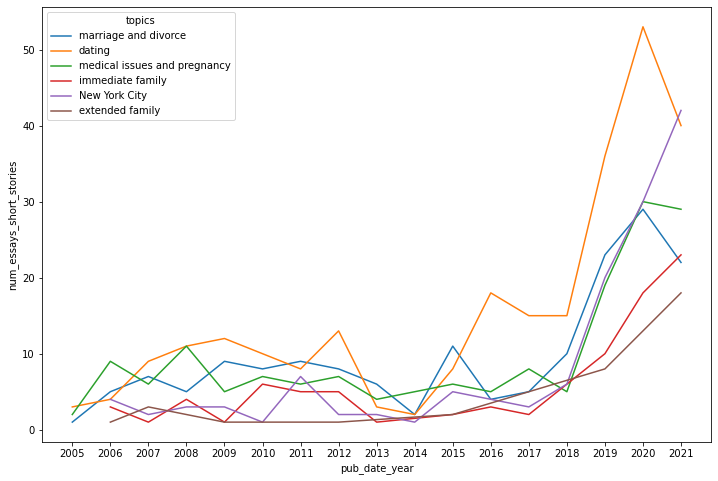

In [261]:
%matplotlib inline 
plt.figure(figsize=(12,8))
sns.lineplot(data=topics_over_time, x='pub_date_year', y='num_essays_short_stories',hue='topics')

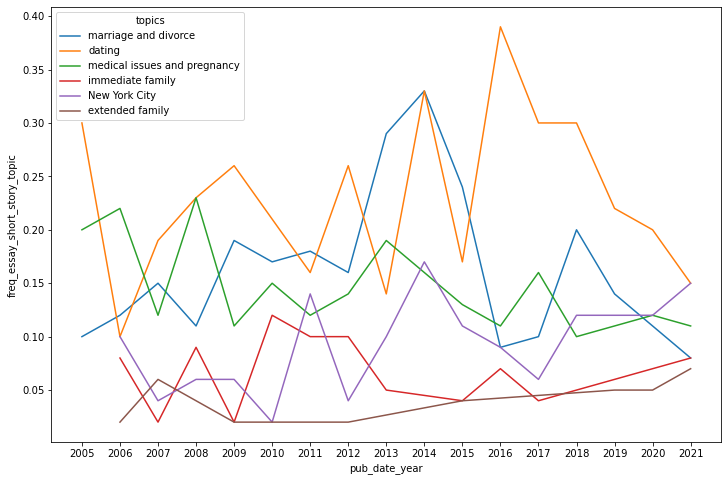

In [262]:
%matplotlib inline 
plt.figure(figsize=(12,8))
sns.lineplot(data=topics_over_time, x='pub_date_year', y='freq_essay_short_story_topic',hue='topics')

# Topic Modeling with LDA

In [612]:
from sklearn.decomposition import LatentDirichletAllocation

In [643]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=.6)
dtm_tfidf = tfidf_vectorizer.fit_transform(corpus)

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm_tfidf)

make_topics(corpus, vectorizer=tfidf_vectorizer, topic_modeler=lda)

Topic 0: mother, father, life, marriage, come, new, look, friend, find, child
Topic 1: look, date, mother, find, marriage, home, life, enjoy, father, leave
Topic 2: mother, look, father, life, new, friend, marriage, date, meet, way
Topic 3: friend, marriage, father, life, date, look, mother, meet, later, come
Topic 4: mother, life, father, child, friend, date, marriage, come, leave, later
Topic 5: mother, marriage, friend, child, father, come, life, meet, look, date
Topic 6: mother, father, husband, child, life, come, look, marriage, friend, new
Topic 7: marriage, mother, husband, father, child, come, life, friend, new, look
Topic 8: mother, life, friend, look, father, parent, find, husband, marriage, child
Topic 9: mother, marriage, look, father, life, new, child, come, husband, date


array([[0.00271592, 0.00271592, 0.00271598, ..., 0.00271596, 0.97555644,
        0.0027159 ],
       [0.00281781, 0.97463828, 0.00281785, ..., 0.00281765, 0.00281902,
        0.00281773],
       [0.00316127, 0.00316124, 0.00316119, ..., 0.00316119, 0.00316201,
        0.00316145],
       ...,
       [0.01012208, 0.908902  , 0.01012163, ..., 0.01012169, 0.01012229,
        0.01012148],
       [0.00801151, 0.00801151, 0.00801154, ..., 0.00801151, 0.92789615,
        0.0080115 ],
       [0.00815031, 0.00815035, 0.0081504 , ..., 0.00815044, 0.00815067,
        0.00815039]])

# Topic Modeling with CorEx

Helpful resources on CorEx
- <a href="https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb">notebook on how to use it</a>

In [93]:
!pip install corextopic
!pip install networkx

In [71]:
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

# Topic modeling utility

In [72]:
def make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=None, anchor_strength=None):
    """A very simple pipeline."""
    
    # Vectorize documents into a document-word matrix
    doc_word = vectorizer.fit_transform(corpus)
    doc_word = ss.csr_matrix(doc_word)
    print(doc_word.shape)
    print("")
    
    # Get words that label the columns (needed to extract readable topics and make anchoring easier)
    words = list(np.asarray(vectorizer.get_feature_names()))
    
    # Fit the model
    topic_model = topic_modeler.fit(doc_word)
    if anchor_words:
        topic_model.fit(doc_word, anchors=anchor_words, anchor_strength=anchor_strength, \
                        words=words, docs=corpus)
    else:
        topic_model.fit(doc_word,words=words, docs=corpus)
    
    
    # Print the topics and top words
    topics = topic_model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
     
    # Print total correlation of each topic and the sum of all topics in the model
    print("")
    print(topic_model.tcs)
    print(topic_model.tc)
    
    return topic_model

# CorEx Baseline model

In [264]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = CountVectorizer(max_features=20000, binary=True)
topic_modeler = ct.Corex(n_hidden=8, seed=1) 

make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=None, anchor_strength=None)

(1458, 20000)

0: way,come,long,life,look,find,good,try,leave,friend
1: information,sidewalk,reference,supply,accord,knowledge,campus,trap,fantasize,current
2: disapprove,equip,undo,naturally,paddle,parameter,sane,relent,accessory,decipher
3: resentment,apple,traumatize,outgrow,logical,underwater,filter,banter,bent,cascade
4: design,shopping,fertility,trait,cart,boil,cure,magic,futon,dish
5: participate,beam,bookstore,branch,stylish,cabinet,bread,minneapolis,charlie,roast
6: chase,previously,abortion,pursuit,gas,curse,prop,bore,fragile,reproductive
7: conform,novelty,unimaginable,award,stroke,chaperone,spreadsheet,arizona,celebration,delhi

[87.72330266  5.32199851  5.10039868  3.38039333  2.96990819  2.71098833
  2.59114962  1.27169641]
111.06983572249246


In [170]:
# import tkinter
# import matplotlib
# import matplotlib.pyplot as plt
# matplotlib.use('TkAgg')

# plt.figure(figsize=(10,5))
# plt.bar(range(topic_model_2.tcs.shape[0]), topic_model_2.tcs, color='#4e79a7', width=0.5)
# plt.xlabel('Topic', fontsize=16)
# plt.ylabel('Total Correlation (nats)', fontsize=16)
# plt.show()

# CorEx Model 2 - add anchor words (words from NFM model)

In [687]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']  # remove girlfriend # remove sex and ex # remove class, teacher, college
vectorizer = CountVectorizer(ngram_range=(1,3),max_features=20000, binary=True)
topic_modeler = ct.Corex(n_hidden=5, seed=1) 
anchor_words = [['father','mother','parent','brother','sister','death'],\
                ['sex','date','boyfriend'],\
                ['divorce','marriage'],\
                ['party', 'high school'],\
                ['birth','doctor','pregnancy','baby']]
anchor_strength = 6

corex_doc_topic = make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=anchor_words, anchor_strength=anchor_strength)

(1458, 20000)

0: parent,father,mother,death,brother,sister,room,family,decide,child
1: date,sex,boyfriend,job,allow,simply,truth,city,act,single
2: marriage,way,come,long,divorce,life,look,find,good,try
3: party,high school,girl,romance,cool,period,brown,painful,certainly,boot
4: baby,doctor,pregnancy,birth,hospital,bright,nurse,machine,healthy,feature

[20.68899194 23.7400969  55.13429811 16.88581432 17.03870544]
133.48790671487816


# Plot top words associated with each topic

The topic words are those with the highest mutual information with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. CorEx also returns the "sign" of each word, which is either 1 or -1. If the sign is -1, then that means the absence of a word is informative in that topic, rather than its presence.

In [688]:
# save the topics and top words associated with each topic (it becomes a list of lists, where each list corresponds
# with a topic and contains tuples with each word, its mutual information, and the word's 'sign'

corex_topics_words = corex_doc_topic.get_topics()

# remove third item in tuple, since we only 
corex_topics_words = [[word[:-1] for word in topic] for topic in corex_topics_words]

In [689]:
# helper function to generate bar charts of topics and their words with the highest mutual info w/ the topic

def create_topic_word_chart(i):
    
    topic_i = []
    
    for topic in corex_topics_words[i]:
        topic_i.append(topic)
        
    words, mi = zip(*topic_i)
    s = pd.Series(mi, words)
    df = pd.DataFrame(s).reset_index().rename(columns={'index':'topic word',
                                                        0:'mutual information'})
    df = df.sort_values('mutual information',ascending=False)
    
    plt.figure(figsize=(5,6))
    sns.set(font_scale=1.5)
    sns.set_style(style='white')
    plt.xlim(0,1)
    sns.barplot(x='mutual information',y='topic word', data=df,color='pink')
    sns.despine(top=True, right=True, left=False, bottom=False)

Plot for family topic

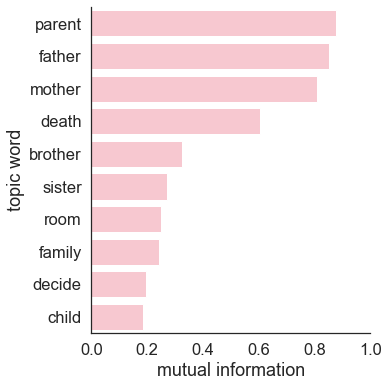

In [690]:
%matplotlib inline
family_plot = create_topic_word_chart(i = 0)
plt.savefig('family_plot.png',bbox_inches='tight')

Plot for dating topic

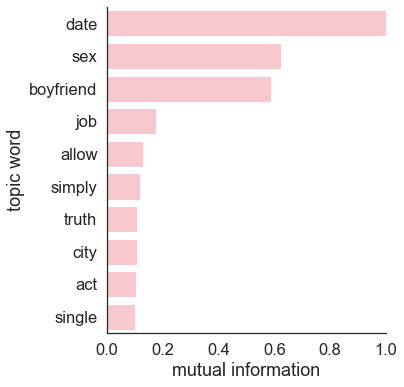

In [691]:
%matplotlib inline
dating_plot = create_topic_word_chart(i = 1)
plt.savefig('dating_plot.png',bbox_inches='tight')

Plot for marriage and divorce topic

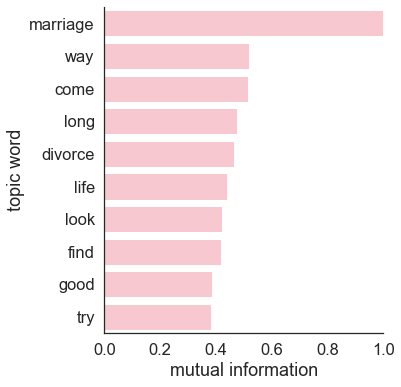

In [692]:
%matplotlib inline
marriage_divorce_plot = create_topic_word_chart(i = 2)
plt.savefig('marriage_divorce_plot.png',bbox_inches='tight')

Plot for school topic

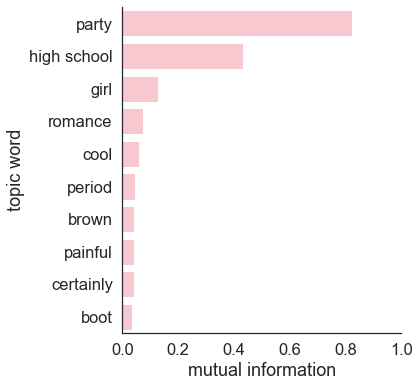

In [693]:
%matplotlib inline
school_plot = create_topic_word_chart(i = 3)
plt.savefig('school.png',bbox_inches='tight')

Plot for pregnancy and birth topic

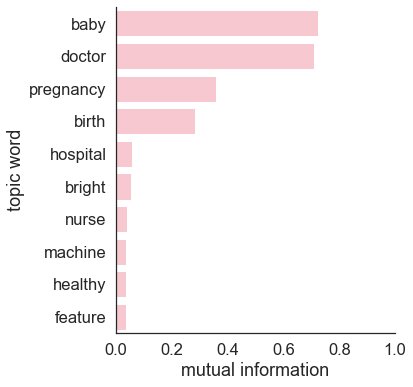

In [694]:
%matplotlib inline
pregnancy_birth_plot = create_topic_word_chart(i = 4)
plt.savefig('pregnancy_birth.png',bbox_inches='tight')

# Map for taking a new document and outputting its topic

In [695]:
# new docs to assign a topic

new_docs = pd.Series(['Durian. It’s love or hate with this fruit. \
            In my family, only Grandma and I were fans. \
            Because of its pungent odor, my family members with milder tastes made a house rule: \
            Durian must be consumed in the parking lot or playground, never indoors. \
            Indignant and banished, I found comfort in Grandma’s solidarity.',
            'The day after an ill-fated second date, I called my little brother as I lay in bed, despondent, \
            in my dingy college apartment. “I don’t have time to come home and do laundry today,” I said. \
            “Oh, and I met someone.” My brother, Felix, listened quietly to my inventory of hesitations: \
            She liked me more than I liked her. She wanted commitment. She lived around the block, and I really \
            didn’t want to hurt her. A pause. My brother said, “You have time for one load. I’ll come get you.”\
            His pragmatic, gentle love is just right. — Ione Madsen Hardy',
           'Being in an abusive relationship is like acting in a play with an erratic director. \
           The script they write unfailingly serves them, affirms them and diminishes you. If you break \
           character (say, hang out with friends or move a houseplant without asking), they will make you pay. \
           So, every day, you get up and improvise to the best of your ability. Day after day of improv, \
           all in service of upholding their narrative and avoiding their wrath. Until, perhaps, you decide to \
           find a partner who will write a story with you, not for you. — Drew Lindgren',
            'Hugh wept talking about his late wife, his best friend. After that first grief support session, I \
            said to my co-facilitator, “I don’t think Hugh will be back.” But he came, all eight weeks. \
            He called it a class, though we kept reminding him it wasn’t. I ran into him months later. \
            I wasn’t looking for romance, but I told him about my swing dance lessons. He asked if he could join; \
            he was such a good dancer. A decade later, politics divide the country. We’re in opposite camps. \
            We can’t watch the news together, but we can dance. — Eileen Vorbach Collins'])

In [696]:
# pre-process new_docs the same ways as the original corpus fit to the model

new_docs = list(nlp.pipe(new_docs))
new_docs_clean = [[token.lemma_.lower() for token in doc if token.is_alpha and \
                          (not token.is_stop and not token.is_punct and not token.like_num and not token.is_digit)] \
                           for doc in new_docs]
new_docs_clean = [' '.join(map(str, l)) for l in new_docs_clean]

new_docs_2 = list(nlp.pipe(new_docs_clean))
new_docs_clean_2 = [[token for token in doc if token.text not in sw_spacy] for doc in new_docs_2]
new_docs_clean_2 = [' '.join(map(str, l)) for l in new_docs_clean_2]
new_docs_clean_2 = list(nlp.pipe(new_docs_clean_2))

new_docs_3 = list(nlp.pipe(new_docs_clean_2))
new_docs_clean_3 = [[token.lemma_ for token in doc] for doc in new_docs_3]
new_docs_clean_3 = [' '.join(map(str, l)) for l in new_docs_clean_3]

CountVectorizer and CorEx first

In [697]:
# vectorize new_docs_clean_3 on vectorizer fit to original corpus

corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=20000, binary=True)
doc_word_vectors = vectorizer.fit_transform(corpus)
new_doc_word_vectors = vectorizer.transform(new_docs_clean_3)

In [698]:
# predict topics for each doc in new_docs_clean_3 on CorEx model fit to original vectorized corpus

new_doc_topic = corex_doc_topic.predict(new_doc_word_vectors)

In [699]:
# create dataframe from new_doc_topic matrix and join it with the text documents

corex_new_doc_topic_df = pd.DataFrame(new_doc_topic, columns=['family','dating','marriage_divorce',
                                                             'school','birth_pregnancy'])

corex_new_doc_topic_df['doc'] = new_docs_clean_3

In [700]:
corex_new_doc_topic_df

,family,dating,marriage_divorce,school,birth_pregnancy,doc
0,False,False,False,True,False,durian love hate fruit family grandmother fan pungent odor family member milder taste house rule durian consume parking lot playground indoor indignant banish find comfort grandmother solidarity
1,False,False,False,False,False,ill fate date little brother lie bed despondent dingy college apartment come home laundry today oh meet brother felix listen quietly inventory hesitation commitment live block hurt pause brother load come pragmatic gentle love right ione madsen hardy
2,False,False,False,False,False,abusive relationship act play erratic director script write unfailingly serve affirm diminish break character hang friend houseplant pay improvise good ability improv service uphold narrative avoid wrath decide find partner write story draw lindgren
3,False,False,False,False,False,hugh weep talk late wife good friend grief support session co facilitator hugh come week class remind run month later look romance swing dance lesson join good dancer decade later politic divide country opposite camp watch news dance eileen vorbach collin


TfidfVectorizer and NMF second (if necessary)

In [709]:
# vectorize new_docs_clean_3 on vectorizer fit to original corpus

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.6, min_df=.01)
doc_word_vectors_nmf = tfidf_vectorizer.fit_transform(corpus)
new_doc_word_vectors_nmf = tfidf_vectorizer.transform(new_docs_clean_3)

In [713]:
# predict topics for each doc in new_docs_clean_3 on NMF model fit to original vectorized corpus

new_doc_topic_nmf = nmf_doc_topic.transform(new_doc_word_vectors_nmf)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

# Prepare dataframe for analysis

In [681]:
corex_doc_topic_df = pd.DataFrame(corex_doc_topic.p_y_given_x) # n_docs x k_topics

In [682]:
corex_doc_topic_df.sample(5)

,0,1,2,3,4
851,0.000001,0.000001,0.000001,0.000001,0.000001
509,0.999999,0.999999,0.999999,0.999999,0.999999
1399,0.000001,0.000001,0.000001,0.000001,0.000001
793,0.000001,0.000001,0.000001,0.000001,0.000001
186,0.999999,0.999999,0.999999,0.999999,0.999999


In [683]:
corex_modern_love_doc_topic_df = modern_love_df_rev_2.join(corex_doc_topic_df)
corex_modern_love_doc_topic_df = corex_modern_love_doc_topic_df.rename(columns={0:'topic_1',1:'topic_2',
                                                                   2:'topic_3',3:'topic_4',
                                                                   4:'topic_5'})

In [684]:
corex_modern_love_doc_topic_df.iloc[:,-5:].sample(5)

,topic_1,topic_2,topic_3,topic_4,topic_5
75,0.999999,0.999999,0.999999,0.999999,0.999999
281,0.999999,0.999999,0.999999,0.000001,0.999999
1508,NaN,NaN,NaN,NaN,NaN
681,0.999999,0.999999,0.999999,0.999999,0.999999
822,0.000001,0.000001,0.000001,0.000001,0.000001


In [680]:
corex_modern_love_doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1608
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                1458 non-null   object
 1   essay              1458 non-null   object
 2   id                 1458 non-null   object
 3   headline           1458 non-null   object
 4   abstract           1458 non-null   object
 5   snippet            1458 non-null   object
 6   lead_paragraph     1450 non-null   object
 7   pub_date           1458 non-null   object
 8   news_desk          1458 non-null   object
 9   section            1458 non-null   object
 10  type_material      1458 non-null   object
 11  word_count         1458 non-null   int64 
 12  essay_rev          1458 non-null   object
 13  essay_rev_clean    1458 non-null   object
 14  essay_rev_clean_2  1458 non-null   object
 15  essay_rev_clean_3  1458 non-null   object
 16  topic_1            1307 non-null   object


In [586]:
corex_modern_love_doc_topic_df.loc['total'] = corex_modern_love_doc_topic_df[['topic_1','topic_2','topic_3','topic_4','topic_5']].sum()

In [587]:
total_docs_per_topic = corex_modern_love_doc_topic_df.iloc[-1:,-5:].values
total_docs_per_topic = [item for sublist in total_docs_per_topic for item in sublist]
topics_list = ['Family','Dating','Marriage and Divorce','School','Pregnancy and Birth']

In [588]:
print(total_docs_per_topic)
print(topics_list)

[634.0, 647.0, 663.0, 611.0, 531.0]
['Family', 'Dating', 'Marriage and Divorce', 'School', 'Pregnancy and Birth']


In [589]:
docs_no_topic = len(corex_modern_love_doc_topic_df.loc[(corex_modern_love_doc_topic_df.topic_1 == False) & \
                                                  (corex_modern_love_doc_topic_df.topic_2 == False) & \
                                                  (corex_modern_love_doc_topic_df.topic_3 == False) & \
                                                  (corex_modern_love_doc_topic_df.topic_4 == False) & \
                                                  (corex_modern_love_doc_topic_df.topic_5 == False)])
docs_no_topic

641

In [590]:
total_docs_per_topic.append(docs_no_topic)
topics_list.append('No topic')

In [591]:
s = pd.Series(total_docs_per_topic, topics_list)
df = pd.DataFrame(s).reset_index().rename(columns={'index':'topic',
                                                        0:'total essays/short stories'})
df = df.sort_values('total essays/short stories',ascending=False)

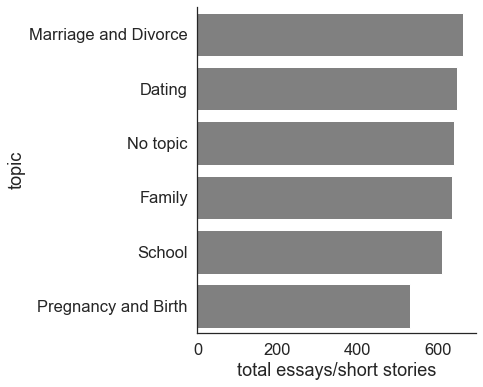

In [592]:
%matplotlib inline

plt.figure(figsize=(5,6))
sns.set(font_scale=1.5)
#sns.set_palette("pastel")
sns.set_style(style='white')
#plt.xlim(0,1)
sns.barplot(x='total essays/short stories',y='topic', data=df, color='gray')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig('docs_per_topic.png',bbox_inches='tight')

In [597]:
# drop total row from df

corex_modern_love_doc_topic_df = corex_modern_love_doc_topic_df.iloc[:-1]

# convert pub_date to datetime and then keep only the date

corex_modern_love_doc_topic_df['pub_date_year'] = pd.DatetimeIndex(corex_modern_love_doc_topic_df['pub_date']).year

In [605]:
corex_modern_love_doc_topic_df.loc[corex_modern_love_doc_topic_df.pub_date_year == '2004']

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,url,essay,id,headline,abstract,snippet,lead_paragraph,pub_date,news_desk,section,...,essay_rev,essay_rev_clean,essay_rev_clean_2,essay_rev_clean_3,topic_1,topic_2,topic_3,topic_4,topic_5,pub_date_year


In [607]:
topics_over_time = corex_modern_love_doc_topic_df.groupby('pub_date_year').agg({'topic_1':'sum','topic_2':'sum',
                                                            'topic_3':'sum','topic_4':'sum',
                                                            'topic_5':'sum'}).reset_index()

In [608]:
topics_over_time

,pub_date_year,topic_1,topic_2,topic_3,topic_4,topic_5
0,2004,False,False,False,False,False
1,2005,0,0,0,0,0
2,2006,0,0,0,0,0
3,2007,42,44,44,38,38
4,2008,46,47,47,45,43
5,2009,47,47,47,46,42
6,2010,48,48,48,47,42
7,2011,48,49,50,47,41
8,2012,47,49,50,47,36
9,2013,21,21,21,20,18


In [ ]:
# # convert pub_date to datetime and then keep only the date

# corex_modern_love_doc_topic_df['pub_date_year'] = pd.DatetimeIndex(corex_modern_love_doc_topic_df['pub_date']).year
# topics_over_time = (corex_modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))

# topics_over_time = (modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))
# topics_over_time['total_essays_short_stories'] = topics_over_time.groupby(['pub_date_year'])['num_essays_short_stories'].transform(lambda x: x.sum())
# topics_over_time['freq_essay_short_story_topic'] = (topics_over_time['num_essays_short_stories'] / \
#                                                    topics_over_time['total_essays_short_stories']).round(2)

# def revise_topics(x):
#     if x == 'topic_1':
#         return 'misc'
#     elif x == 'topic_2':
#         return 'immediate family'
#     elif x == 'topic_3':
#         return 'marriage and divorce'
#     elif x == 'topic_4':
#         return 'dating'
#     elif x == 'topic_5':
#         return 'family'
#     elif x == 'topic_6':
#         return 'New York City'
#     elif x == 'topic_7':
#         return 'medical issues and pregnancy'
#     else:
#         return 'extended family'
    
# topics_over_time['topics'] = topics_over_time['topics'].map(revise_topics)

In [540]:
# Let's check out topic : graphics
corex_doc_topic.get_top_docs(topic=0, n_docs=2)

[('leave south dakota rex sit talk beneath open hatchback car distance lightning storm open expanse great plain churn sky murky purple talk passionately lithium battery talk common consider interested especially attract speak care battery volunteer pine ridge reservation build repair infrastructure greet arrive end long dirt road climb cab skid loader face body warm lyrical version happen storm approach stop talk seriously pleasure body baby date late poem math problem lot line look differ young self envision care date certain baby love get marriage biological father child maybe admire arrive set criterion alternative sentimental unrealistic especially husband wish list champion year ready able child help sit meditation practice observe worry pregnancy discerning love effect fear intensify old trust judgment pressure lot start smell father decide safe way protect romantic delusion separate story outset try find mate mother biological constraint easy figure urgent resolve child outside 

# CorEx Model 3 - tune max_df, min_df and ngrams

In [273]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = CountVectorizer(ngram_range=(1,3),max_features=20000,binary=True,min_df=.01)
topic_modeler = ct.Corex(n_hidden=5, seed=1) 
anchor_words = [['father','mother','parent','brother','sister'],\
                ['sex','date','boyfriend','girlfriend','message'],\
                ['divorce','ex','sex','marriage'],\
                ['school','class','teacher','college'],\
                ['birth','doctor','pregnancy','baby']]
anchor_strength = 6

make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=anchor_words, anchor_strength=anchor_strength)

(1458, 4031)

0: parent,father,mother,brother,begin,sister,family,stand,real,child
1: date,message,sex,girlfriend,boyfriend,online,profile,start date,mail message,text message
2: marriage,sex,way,come,long,divorce,life,look,find,good
3: school,college,class,place,early,watch,word,follow,realize,read
4: baby,doctor,pregnancy,birth,hospital,nurse,healthy,intensive,intensive care,infant

[37.19150201  4.61985162 32.22584163 18.99416746  3.66741986]
96.6987825730295


Topic 0 essays
- https://www.nytimes.com/2012/05/13/fashion/modern-love-paralysis-of-the-heart.html - "With my son, Joe, I wasn’t fearless. Quite the opposite, I was petrified by how much I loved him." (author talks about love for her son when she has an MRI done for numbness in her body)
- https://www.nytimes.com/2015/03/22/style/together-always-in-darkness-and-in-light.html - author talks about going blind and how this impacted her and her husband's decision to have another baby
- https://www.nytimes.com/2012/03/11/fashion/a-small-lump-challenges-a-prediction.html "The psychic’s predictions were three-for-three. But what about the most important one?" (author talks about a benign tumor)

Topic 1 essays
- https://www.nytimes.com/2006/11/12/fashion/12love.html - "Pledging much more than his heart"
- https://www.nytimes.com/2019/08/23/style/modern-love-lets-meet-again-in-five-years.html - "They thought college was too soon for lifelong love, so they scheduled their next date for a little later — 60 months."
- https://www.nytimes.com/2017/05/19/style/modern-love-not-friends-then-no-benefits.html - "A woman who feels no sexual attraction without first establishing a deep emotional connection wonders if there is something wrong with her."

Topic 2 essays
- https://www.nytimes.com/2011/04/10/fashion/03Modern.html	'A grand wedding dress can stir up latent longings, even in a modest bride.'
- https://www.nytimes.com/2008/06/15/fashion/15love.html - "My one slim shot at redemption: learn his hat size."

Topic 3 essays
- https://www.nytimes.com/2012/11/04/fashion/the-mixed-politics-marriage.html - "Two teachers of conflict resolution navigate a marriage straddling the political left and right."
- https://www.nytimes.com/2021/04/16/style/modern-love-muslim-hindu-dating.html - "As a Pakistani Muslim, I knew that falling for a Hindu Indian would break me. And it did."

Topic 4 essays 
- https://www.nytimes.com/2020/05/29/style/modern-love-coronavirus-why-are-all-the-exes-texting.html - "Not since The New York Post said I was dead have so many friends and lovers checked in on me."
- https://www.nytimes.com/2016/10/09/fashion/modern-love-trump-clinton-family-affair.html - "In midlife, a man quickly forges a tight bond with a sister he never knew he had, until the presidential campaign threatens to pull them apart."

Topic 5 essays
- https://www.nytimes.com/2018/10/26/style/modern-love-im-the-man.html - "Stung by divorce, a high-earning professional tries to recast herself in the dating world as a woman in need of male protection."
- https://www.nytimes.com/2008/06/29/fashion/29love.html - "Sometimes we have to fight battles even when we don't want to."
- https://www.nytimes.com/2013/06/02/fashion/My-Husbands-New-Son-Modern-Love.html - "Hypothetically, donating sperm so friends can have a baby is a simple decision."

Topic 6 essays
- https://www.nytimes.com/2019/06/21/style/modern-love-tarot-cards-destiny.html - "A tarot card reader said my ex would come back to me in three years. Until then, I was supposed to have relationships that fail." (author moves home)
- https://www.nytimes.com/2017/09/01/style/modern-love-whos-allowed-to-hold-hands.html - "A Jamaican woman chafes at the reality that expressing affection for her wife can lead to confrontations with her fellow immigrants in New York." (author talks about looks she and her partner get while holding hands as a black lesbian couple and describes Brooklyn and her homeland of Jamaica as places different from each other)

Topic 7 essays
- https://www.nytimes.com/2020/03/27/style/modern-love-coronavirus-seattle-kirkland.html - "Separated from family and worried about patients and colleagues, an internist where the U.S. outbreak began counts losses and blessings." (talks about his work in a hospital at beginning of pandemic)
- https://www.nytimes.com/2021/07/16/style/it-took-me-a-long-time-to-come-out-as-a-plushie-lover.html - "As the second wave of coronavirus battered us in India, my partner and I found solace and pride in our stuffed animals." (author talks about how it took her a long time to come out as a stuffed animal lover)

# CorEx Model 4 - TF-IDF

In [82]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = TfidfVectorizer(max_features=20000)
topic_modeler = ct.Corex(n_hidden=8, seed=1)  

make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=None, anchor_strength=None)

(1458, 20000)

0: way,come,friend,life,relationship,marriage,long,talk,sex,kind
1: akari,frieda,deji,gerri,est,nar,shottsy,que,désolé,cecilia
2: aadmi,pine,pidgin,piano,physics,photocopy,phony,phoebe,phnom,philosophical
3: aaaarrrrgh,pneumonia,plush,plume,plow,plight,pliable,playroom,playoff,playful
4: melina,preston,aah,ponce,pond,ponder,pong,pomplamoose,ponytail,poop
5: aahed,poker,pointillist,poetic,podcast,pocketful,poach,plexu,playhouse,platitude
6: aaa,phu,phonebook,phobic,phobia,phobe,phloem,philosopher,philistines,pharmaceutical
7: greta,aa,prohibition,prohibit,productive,proclaim,proactive,prix,privilege,princeton

[7.16534688e-01 2.19495301e-03 2.40788610e-04 2.02379155e-04
 6.08145305e-05 3.63154012e-05 2.24060036e-05 1.89872635e-05]
0.7193113324286294


# CorEx Model 5 - TF-IDF and tune max_df, min_df and ngrams

In [83]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = TfidfVectorizer(ngram_range=(1,3),max_df=0.8, min_df=0.01)
topic_modeler = ct.Corex(n_hidden=8, seed=1) 

make_topics_cx(corpus, vectorizer,topic_modeler,anchor_words=None, anchor_strength=None)

(1458, 4032)

0: way,come,friend,life,relationship,long,talk,marriage,kind,look
1: absolutely,nephew,occupy,oh yeah,opinion,overhead,overwhelming,paperwork,paralyze,parent home
2: absorb,professor,progressive,psychiatrist,punch,pure,rank,real world,recipe,replace
3: adoration,ok,old son,paris,parking lot,participate,pattern,pause,payment,permit
4: accustomed,noodle,northern,november,obscure,obsess,obsession,old child,parent divorce,parenting
5: accidentally,new boyfriend,new yorker,newfound,newly,nightly,oblivious,open door,organize,overcome
6: abroad,potato,poverty,proudly,purse,range,rate,reach hand,reader,refugee
7: acquaintance,pillow,poem,poetry,polish,popular,portrait,poster,pretty good,program

[ 9.82199161e-01  1.39147348e-04  1.04990265e-04  4.16248182e-05
  2.72979791e-06 -5.69772392e-06 -2.38193070e-05 -7.30841294e-05]
0.9823850518640102


# CorEx Model 6 - TF-IDF and anchor words

In [84]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = TfidfVectorizer(max_features=20000,ngram_range=(1,3),max_df=0.8, min_df=.01)
topic_modeler = ct.Corex(n_hidden=8, seed=1) 
anchor_words = [['father','mother','parent','brother','sister'],\
                ['sex','date','boyfriend','girlfriend','message'],\
                ['divorce','ex','sex','marriage'],\
                ['new york','new york city','apartment','manhattan'],\
                ['high school','school','class','teacher','college'],\
                ['birth','doctor','pregnancy','baby']]
anchor_strength = 2

make_topics_cx(corpus, vectorizer,topic_modeler,anchor_words=anchor_words, anchor_strength=anchor_strength)

(1458, 4032)

0: accidentally,punk,puppy,purse,rare,react,recall,recognition,relationship year,relax
1: ache,performance,philadelphia,politic,poorly,portrait,poverty,profound,progress,proud
2: admission,old daughter,olive,online date,opening,orange,oregon,organize,overwhelmed,pace
3: abroad,new year eve,new york,new york city,newfound,nickname,noodle,november,nudge,nursing
4: way,come,friend,life,relationship,long,talk,kind,look,guy
5: accident,peanut,picnic,pink,playful,poet,politely,pose,pregnancy,property
6: accompany,oxygen,pancake,paperwork,park,partnership,patch,path,paycheck,peek
7: absolutely,overwhelm,overwhelming,parade,paralyze,parent home,passenger seat,pattern,pepper,permanently

[-2.08560363e-05 -1.54611908e-06 -3.67686332e-05  1.17328788e-06
  9.55899686e-01 -4.14849007e-06 -1.57200163e-05 -5.48450748e-06]
0.9558163353714854


# Find optimal number of topics using CorEx algorithm

Got help with the below code from this source: https://github.com/keryums/topic_modelling_demo

In [120]:
def get_corex_topics(num_topics_list, docs, features, print_flag = False):
    """
    outputs correlation list for model selection
    """
    
    total_corr = []
    for i in num_topics_list:
        topic_model = ct.Corex(n_hidden=i, seed = 10)
        topic_model.fit(docs, words=features) 
        total_corr.append(topic_model.tc)
        
        if print_flag == True:
            topics = topic_model.get_topics()
            print('Num topics: ', i)
            for topic_n, topic in enumerate(topics):
                words,mis = zip(*topic)
                topic_str = str(topic_n+1)+': '+', '.join(words)
                print(topic_str)
            print('')

    return total_corr

In [121]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = CountVectorizer(ngram_range=(1,3),max_features=20000, binary=True, max_df=.8, min_df=.003)
doc_word = vectorizer.fit_transform(corpus)
words = list(np.asarray(vectorizer.get_feature_names()))
num_topics = list(range(2,25,1))
correlation = get_corex_topics(num_topics,doc_word,words)

In [314]:
import tkinter
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')

plt.plot(num_topics, correlation)
plt.title('Correlation Plot')
plt.show()

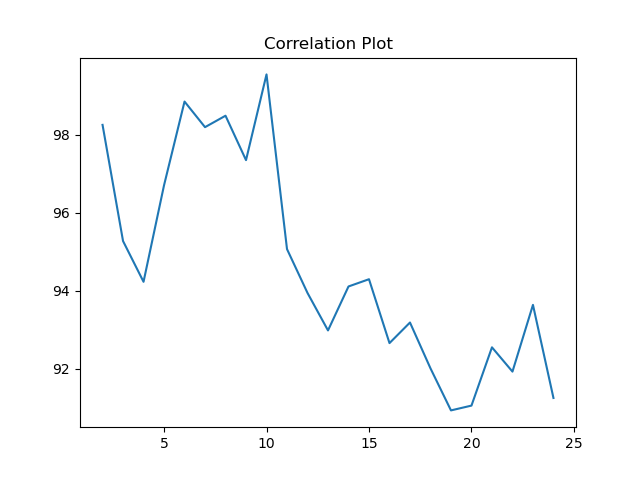

Looks like 6-7 topics is most useful.

# Word embeddings

Learn the embeddings (i.e., train a word embedding model on the corpus)

In [320]:
#!pip install gensim
from gensim.models import Word2Vec

In [321]:
# train the word embedding model 
model = Word2Vec(modern_love_df_rev_2['essay_rev_2'], 
                 window=5,       
                 min_count=1,     
                 sg=True          
      )

In [323]:
# vectorize each document as the mean of its word embeddings 
docs_2_vectorized = []

for tokens in modern_love_df_rev_2['essay_rev_2']:
    zero_vector = np.zeros(model.vector_size)
    vectors = []
    for token in tokens:
        if token in model.wv:
            try:
                vectors.append(model.wv[token])
            except KeyError:
                continue
    if vectors:
        vectors = np.asarray(vectors)
        avg_vec = vectors.mean(axis=0)
        docs_2_vectorized.append(avg_vec)
    else:
        docs_2_vectorized.append(zero_vector)

In [324]:
docs_2_vectorized[0]

array([-0.02292322,  0.11803443,  0.056697  ,  0.17046551, -0.0160349 ,
       -0.10827011,  0.09078135,  0.15055017, -0.09003785, -0.08001582,
        0.03393637, -0.07850459,  0.028249  ,  0.02411185,  0.06860852,
        0.04813413,  0.04753981,  0.00038851, -0.05853344, -0.14375518,
        0.06361146,  0.08414424,  0.05859685, -0.03158077,  0.02283609,
        0.05255172, -0.05295407,  0.04496053, -0.02690911, -0.05190751,
        0.06283175, -0.13222581,  0.04286587, -0.06210323, -0.01756327,
        0.01250572,  0.08230612,  0.0385306 , -0.0380304 , -0.01950155,
        0.03422677, -0.02054968, -0.09334978,  0.0378869 ,  0.0287994 ,
       -0.04882548, -0.1340217 ,  0.02269005,  0.08922879,  0.04429869,
        0.00321754, -0.06913037, -0.03306342,  0.01104861, -0.05159345,
        0.0267301 ,  0.03473747, -0.09021342, -0.03684847, -0.01571581,
       -0.01827681,  0.01066743,  0.19028158,  0.03755265, -0.06211346,
        0.15764627, -0.04949429,  0.11437193, -0.09585208,  0.00

# K-means clustering on NMF doc-topic matrix

In [124]:
from sklearn.cluster import KMeans

In [122]:
corpus = modern_love_df_rev_2['essay_rev_3']
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.6, min_df=.02)
doc_word_matrix = vectorizer.fit_transform(corpus)
nmf_topic_modeler = NMF(8, random_state=42, max_iter=1000)
doc_topic_matrix = nmf_topic_modeler.fit_transform(doc_word_matrix)

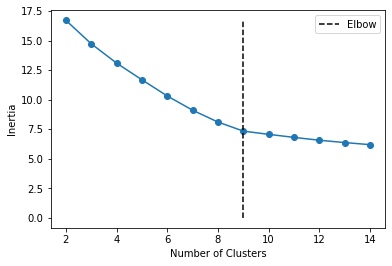

In [130]:
%matplotlib inline 

cluster_range = range(2, 15)

inertias = []

for k in cluster_range:
    km = KMeans(n_clusters=k)
    km.fit(doc_topic_matrix) 
    inertias.append(km.inertia_)
    
plt.plot(cluster_range, inertias)
plt.scatter(cluster_range, inertias)
plt.vlines(x=9, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()

It appears that the "elbow" of the curve at 9 clusters, so we'll do K-means clustering with k=9.

In [140]:
# helper function that allows us to display data in 2 dimensions and highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

IndexError: string index out of range

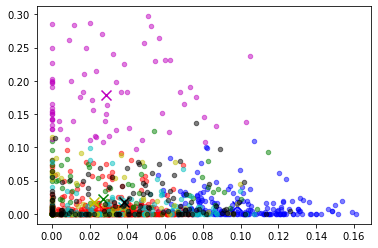

In [141]:
num_clusters = 9
X = doc_topic_matrix
km = KMeans(n_clusters=num_clusters,n_init=1,random_state=42)
km.fit(X)
display_cluster(X,km,num_clusters=num_clusters)

Create custom factory to add to spacy pipeline to remove entities whose labels are 'PERSON'

In [76]:
#@Language.component('person_removal')
#def person_removal(doc):
#    ents = list(doc.ents)
   # for ent in ents:
   #     if ent.label_ == 'PERSON':
    #        ents.remove(ent)
   # ents = tuple(ents)
  #  doc.ents = ents
   # return (doc)
#Language.component("person_removal", func=person_removal)

In [77]:
#nlp.add_pipe('person_removal')

In [78]:
#print(nlp.pipe_names)

The below cell did run

In [33]:
# tokenization into words and parts of speech tagging

#from nltk.tokenize import word_tokenize, sent_tokenize
#from nltk.tag import pos_tag

#tokens = [pos_tag(word_tokenize(row)) for row in modern_love_df['essay']] # labels each word as a part of speech

The below cell ran but took a while to do so

In [ ]:
# named entity recognition

#from nltk.chunk import ne_chunk

#entities = [ne_chunk(token) for token in tokens] # this extracts entities from the list of words
#entities.draw()

The below cell did run

In [22]:
# Import module
#from nltk.tokenize import RegexpTokenizer
#from nltk.tag import pos_tag

# Create an instance of RegexpTokenizer for alphanumeric tokens
#tokeniser = RegexpTokenizer(r'\w+')

# Tokenize text and tag parts of speech
#tokens = [pos_tag(tokeniser.tokenize(row)) for row in modern_love_df['essay']] # labels each word as a part of speech

The below cell didn't work for me

In [40]:
# function to remove tuples in tokens that contain 'NNP' or 'NNPS'

#def remove_items(lst, item):
    #r = []
    #for i in lst:
       # if isinstance(i, list):
        #    r.append(remove_items(i, item))
       # elif item not in i:
         #   r.append(i)
   # return r

In [41]:
# remove proper nouns from tokenized text
#tokens_rev = remove_items(tokens,'NNP')
#tokens_rev = remove_items(tokens,'NNPS')

The below cell didn't work for me

In [43]:
#def filter_nnp_nnps(x):
  #  return [(u,v) for (u,v) in x if (v !='NNP') | (v != 'NNPS')]

#tokens_rev = [filter_nnp_nnps(sub_list) for sub_list in tokens]

The below cell works

In [30]:
# remove numbers and punctuation in essay column
    # used this resource: https://datagy.io/python-remove-punctuation-from-string/

#alphanumeric = lambda x: re.sub('[^a-zA-Z]', ' ', str(x)) # removes numbers
#punc_lower = lambda x: re.sub(r'[^\w\s]', ' ',str(x).lower()) # removes punctuation and makes all letters lowercase

#modern_love_df_rev['essay_rev'] = modern_love_df_rev.essay.map(alphanumeric).map(punc_lower)